In [1]:
using Lux, Flux, Zygote, Optimization
using Random, ComponentArrays

struct HamiltonianNN{M <: Lux.AbstractExplicitLayer} <: Lux.AbstractExplicitContainerLayer{(:model,)}
    model::M
    ad
end


function HamiltonianNN(model)
    !(model isa Lux.AbstractExplicitLayer) && (model = Lux.transform(model))
    return HamiltonianNN(model, Optimization.AutoZygote())
end

function (hnn::HamiltonianNN{<: Lux.AbstractExplicitLayer})(state, ps, st)
    model = Lux.StatefulLuxLayer(hnn.model, nothing, st)
    dH = first(Zygote.gradient(sum ∘ model, state, ps))
    n = size(state, 1) ÷ 2
    return vcat(selectdim(dH, 1, (n + 1):(2n)), -selectdim(dH, 1, 1:n)), model.st
end


hnn = HamiltonianNN(Flux.Chain(Flux.Dense(2 => 16, tanh), Flux.Dense(16 => 1)))
ps, st = Lux.setup(Random.default_rng(), hnn)
ps = ps |> ComponentArray

ComponentVector{Float32}(layer_1 = (weight = Float32[-0.36032352 0.44335154; 0.03113219 -0.03012541; … ; -0.3858019 0.056832805; 0.28032404 -0.27824965], bias = Float32[0.0; 0.0; … ; 0.0; 0.0;;]), layer_2 = (weight = Float32[-0.57581764 0.077997155 … 0.057040196 0.12459021], bias = Float32[0.0;;]))

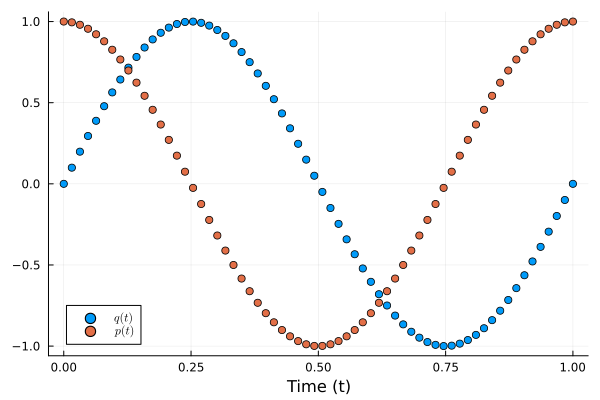

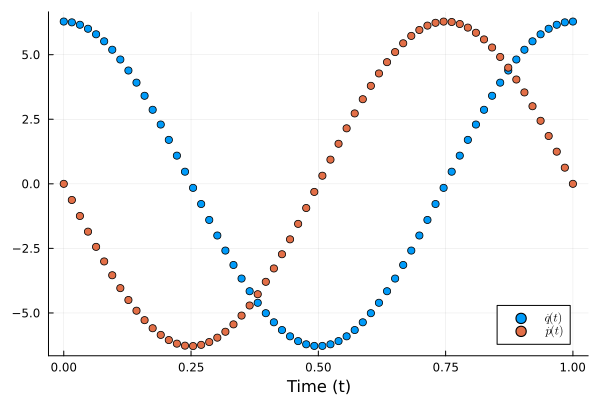

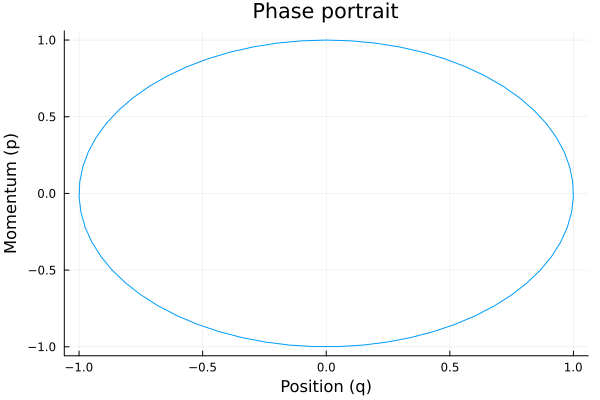

In [2]:
using Plots, LaTeXStrings

π_32 = Float32(π)
tspan = (0.0f0, 1.0f0)
tsteps = range(tspan[1], tspan[2]; length = 64)

q_t = reshape(sin.(2π_32 * tsteps), 1, :)
p_t = reshape(cos.(2π_32 * tsteps), 1, :)
data = vcat(q_t, p_t)

dqdt = 2π_32 .* p_t
dpdt = -2π_32 .* q_t
target = vcat(dqdt, dpdt)

plt = scatter(tsteps, data[1, :], label=L"q(t)")
scatter!(plt, tsteps, data[2, :], label=L"p(t)")
xlabel!("Time (t)")
title!("Data")
display(plot(plt))

plt = scatter(tsteps, target[1, :], label=L"\dot{q}(t)")
scatter!(plt, tsteps, target[2, :], label=L"\dot{p}(t)")
xlabel!("Time (t)")
title!("Target")
display(plot(plt))

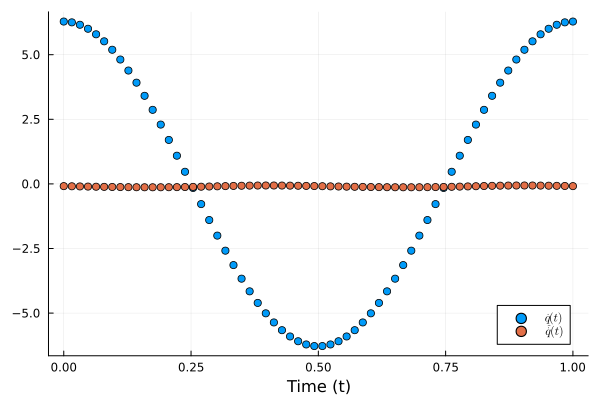

In [3]:
function loss_function(ps, data, target)
    pred, _ = hnn(data, ps, st)
    return sum(abs2, pred .- target), pred
end

l, pred = loss_function(ps, data, target)

plt = scatter(tsteps, target[1, :], label=L"\dot{q}(t)")
scatter!(plt, tsteps, pred[1, :], label=L"\hat{\dot{q}}(t)")
xlabel!("Time (t)")
display(plot(plt))

Hello!false
1
[Hamiltonian NN] Loss: 2528.3774
2
[Hamiltonian NN] Loss: 2518.355
3
[Hamiltonian NN] Loss: 2509.073
4
[Hamiltonian NN] Loss: 2499.8633
5
[Hamiltonian NN] Loss: 2489.985
6
[Hamiltonian NN] Loss: 2479.0454
7
[Hamiltonian NN] Loss: 2466.9111
8
[Hamiltonian NN] Loss: 2453.5115
9
[Hamiltonian NN] Loss: 2438.7937
10
[Hamiltonian NN] Loss: 2422.7031
11
[Hamiltonian NN] Loss: 2405.186
12
[Hamiltonian NN] Loss: 2386.1902
13
[Hamiltonian NN] Loss: 2365.6636
14
[Hamiltonian NN] Loss: 2343.5557
15
[Hamiltonian NN] Loss: 2319.8193
16
[Hamiltonian NN] Loss: 2294.4084
17
[Hamiltonian NN] Loss: 2267.2834
18
[Hamiltonian NN] Loss: 2238.409
19
[Hamiltonian NN] Loss: 2207.758
20
[Hamiltonian NN] Loss: 2175.3123
21
[Hamiltonian NN] Loss: 2141.0613
22
[Hamiltonian NN] Loss: 2105.0073
23
[Hamiltonian NN] Loss: 2067.1638
24
[Hamiltonian NN] Loss: 2027.5548
25
[Hamiltonian NN] Loss: 1986.2195
26
[Hamiltonian NN] Loss: 1943.2094
27
[Hamiltonian NN] Loss: 1898.5879
28
[Hamiltonian NN] Loss: 1852.

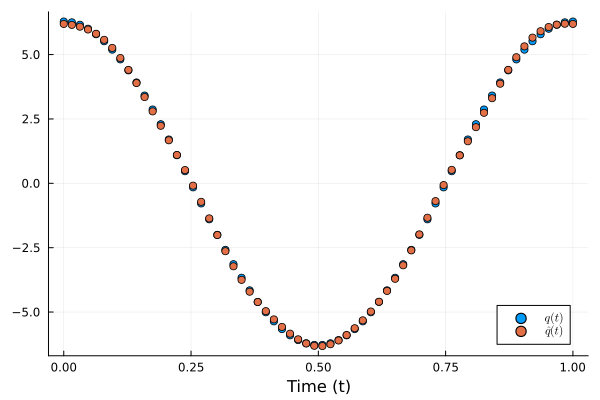

In [14]:
using OptimizationOptimisers

opt = OptimizationOptimisers.Adam(0.01f0)
opt_func = Optimization.OptimizationFunction((u, p) -> loss_function(u, data, target), Optimization.AutoZygote())
opt_prob = Optimization.OptimizationProblem(opt_func, ps)

callback = function (ps, loss, pred)
    println("[Hamiltonian NN] Loss: ", loss)
    return false
end

opt_res = Optimization.solve(opt_prob, opt; callback, maxiters = 300)

ps_trained = opt_res.u
final_loss, pred = loss_function(ps_trained, data, target)

plt = scatter(tsteps, target[1, :], label=L"q(t)")
scatter!(plt, tsteps, pred[1, :], label=L"\hat{q}(t)")
xlabel!("Time (t)")
display(plot(plt))

In [13]:
using DiffEqFlux, OrdinaryDiffEq

struct NeuralHamiltonianDE{M <: HamiltonianNN} <: DiffEqFlux.NeuralDELayer
    model::M
    tspan
    args
    kwargs
end

function NeuralHamiltonianDE(model, tspan, args...; kwargs...)
    hnn = model isa HamiltonianNN ? model : HamiltonianNN(model)
    return NeuralHamiltonianDE(hnn, tspan, args, kwargs)
end

function (nhde::NeuralHamiltonianDE)(x, ps, st)
    model = Lux.StatefulLuxLayer(nhde.model, nothing, st)
    neural_hamiltonian(u, p, t) = model(u, p)
    prob = ODEProblem{false}(neural_hamiltonian, x, nhde.tspan, ps)
    sensealg = InterpolatingAdjoint(; autojacvec = ZygoteVJP())
    return solve(prob, nhde.args...; sensealg, nhde.kwargs...), model.st
end


model = NeuralHamiltonianDE(hnn, tspan, OrdinaryDiffEq.Tsit5(); 
            save_everystep = false, save_start = true, saveat = tsteps)

NeuralHamiltonianDE(
    model = HamiltonianNN(
        model = Chain(
            layer_1 = Dense(2 => 16, tanh_fast),  # 48 parameters
            layer_2 = Dense(16 => 1),   # 17 parameters
        ),
    ),
)         # Total: 65 parameters,
          #        plus 0 states.

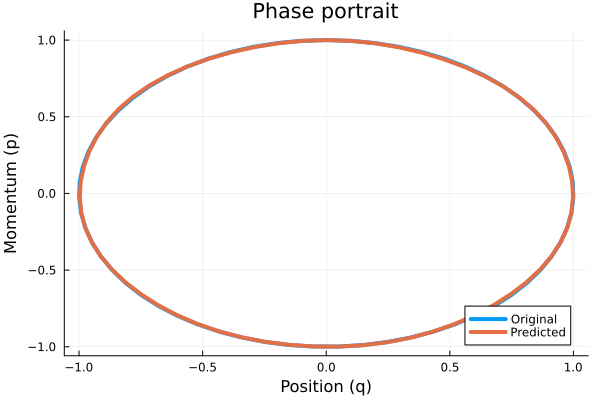

In [12]:
pred = Array(first(model(data[:, 1], ps_trained, st)))

plot(data[1, :], data[2, :]; lw = 4, label = "Original")
plot!(pred[1, :], pred[2, :]; lw = 4, label = "Predicted")
xlabel!("Position (q)")
ylabel!("Momentum (p)")
title!("Phase portrait")